# Solutions for Lab Sheet 8 (COM3502-4502-6502 Speech Processing)

This lab sheet is part of the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield").

It is probably easiest to open this Jupyter Notebook with [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true "Open in Google Colab") since GitHub's Viewer does not always show all details correctly. <a href="https://colab.research.google.com/github/sap-shef/SpeechProcesssingLab/blob/main/Lab-Sheets/Lab-Sheet-8.ipynb"><img align="right" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Notebook in Google Colab" title="Open and Execute the Notebook directly in Google Colaboratory"></a>

Please put questions, comments and correction suggestions in the [Blackboard](https://vle.shef.ac.uk) discussion board or send an email to [s.goetze@sheffield.ac.uk](mailto:s.goetze@sheffield.ac.uk).

<div class="alert alert-block alert-success" id='ILOs'>
<strong>Intended Learning Objectives (ILOs):</strong><br>
    
After completing this Jupyter Notebook you should
    
<ul>
<li>have familiarised yourself with the concept of the <a href="https://en.wikipedia.org/wiki/Overlap%E2%80%93add_method"><code>Overlap-add algorithm</code></a>
</li> 
<li>Be able to implement your own Overlap-add function
</li>    
<li>Understand the concept of <a href="https://wiki.aalto.fi/display/ITSP/Windowing"><code>Perfect Reconstruction</code></a> and the Princen-Bradley criteria
</li>
<li>familiarise yourself with the basic use of the <code>Python</code> libraries 
    <ul>
    <li><a href="https://numpy.org/doc/stable/index.html"><code>Numpy</code></a> commands 
        <a href="https://numpy.org/doc/stable/reference/generated/numpy.pad.html"><code>pad()</code></a>,
        <a href="https://numpy.org/doc/stable/reference/generated/numpy.append.html"><code>append()</code></a>,
        <a href="https://numpy.org/doc/stable/reference/generated/numpy.hamming.html"><code>hamming()</code></a>,
        <a href="https://numpy.org/doc/stable/reference/generated/numpy.hanning.html"><code>hanning()</code></a>,
        <a href="https://numpy.org/doc/stable/reference/generated/numpy.blackman.html"><code>blackman()</code></a>,
        etc.
    </li>
    <li><a href="https://matplotlib.org/"><code>Matplotlib</code></a> for graphical output (like 
        <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.gca.html"><code>gca()</code></a>, 
        <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.gcf.html"><code>gcf()</code></a>, 
        etc.)
    </li>
    </ul>
</li>
</ul>
</div>

In [1]:
# Let's do the ususal necessary and nice-to-have imports
%matplotlib notebook
import matplotlib.pyplot as plt  # plotting
import seaborn as sns; sns.set() # styling ((un-)comment if you want)
import numpy as np               # math

# imports we need in addition for this lab sheet
from IPython import display as ipd
import scipy.signal as sig
import soundfile as sf
from scipy.io.wavfile import read as wavread

C:\Users\stefan\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<br>
<a id='task_1'></a>
<div class="alert alert-block alert-info">
    
**Task 1: (Mixing of Speech and Noise)**
    
<ul>
<li> 
    Load a WAVE file containing speech, e.g. <code>speech_8kHz_murder.wav</code> from the Internet address <code>https://staffwww.dcs.shef.ac.uk/people/S.Goetze/sound/</code> and load it into a variable <code>s</code>.
</li>
    <li> 
    Generate a signal of white noise of the same length as your speech signal and load it into a variable <code>n</code>. Refer to <a href="https://colab.research.google.com/github/sap-shef/SpeechProcesssingLab/blob/main/Lab-Sheet-Solutions/Lab-Sheet-6-Solution.ipynb#scrollTo=18ff79b8">Lab Sheet 6</a> for help. Normalise the amplitude of the noise signal to have an ampliude of $0.2$ (to avoid that it is too loud).
</li>
  <li>   
    Create a microphone signal $y[k] = s[k]+n[k]$ as shown in the schematic below. 

<img id='FigNRSingleChannelBasic' src="https://staffwww.dcs.shef.ac.uk/people/S.Goetze/book/Chp5SignalEnhancementNR/images/NRSingleChannelBasic-web.png" align="center"/>
      <center><span style="font-size:smaller">
    <b>Fig. 1:</b> Noise reduction filter $h[k]$ aiming to reduce the noise component $n[k]$ from the noisy microphone signal $y[k]$ to obtain an estimate of the clean speech signal $\hat{s}[k]$.
</span></center>
    </li> 
</ul>
</div>

In [2]:
# load speech wave into variable
s_file_name = 'speech_8kHz_murder.wav'
!curl https://staffwww.dcs.shef.ac.uk/people/S.Goetze/sound/{s_file_name} -o {s_file_name} 

s, fs = sf.read(s_file_name)
print('File "' + s_file_name + '" loaded. Its sampling rate is ' + str(fs) + ' Hz.')

File "speech_8kHz_murder.wav" loaded. Its sampling rate is 8000 Hz.


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  328k    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  328k  100  328k    0     0  2368k      0 --:--:-- --:--:-- --:--:-- 2383k


In [3]:
# generate Gaussian white noise
n = np.random.normal(size=len(s))
# normalise noise to amplitude 1
n = n / np.max(np.abs(n))
# and now to a maximum amplitude of 0.2
n = n * 0.2

As done before we can listen to the signals:

In [4]:
# listen to the speech file (if you want)
ipd.Audio(s, rate=fs)

In [5]:
# listen to the noise file (if you want)
ipd.Audio(n, rate=fs)

In [6]:
# create noisy microphone signal as depicted in Fig. 1
y = s + n

In [7]:
# listen to the modelled microphone signal (if you want)
ipd.Audio(y, rate=fs)

or we could visualise then by plotting.

<IPython.core.display.Javascript object>


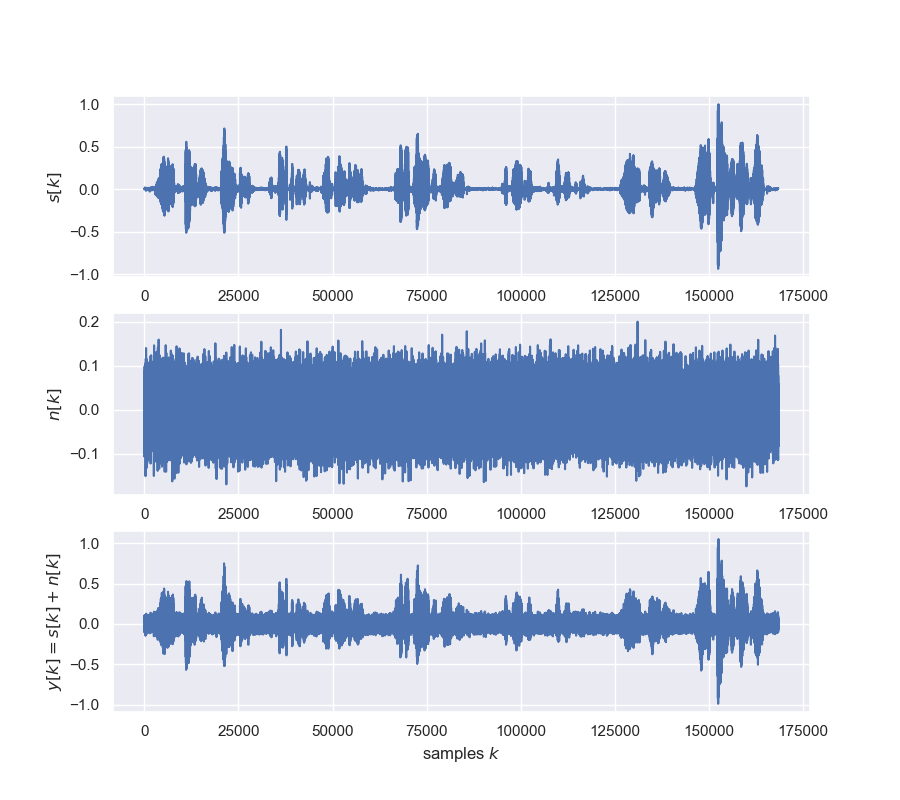

In [8]:
plt.figure(figsize=(9,8))
plt.subplot(3,1,1)
plt.plot(s)
plt.ylabel('$s[k]$')
plt.subplot(3,1,2)
plt.plot(n)
plt.ylabel('$n[k]$')
plt.subplot(3,1,3)
plt.plot(y)
plt.ylabel('$y[k]=s[k]+n[k]$')
plt.xlabel('samples $k$');

From listening to the sound files as well as from comparing clean speech signal $s[k]$ and noisy signal $y[k]$ in the figure above, the effect of the noise should be obvious.

# Overlap-add Processing

When processing signals with long duration, it is common practise to do so by splitting the long signal into a series of shorter segments or chunks, a.k.a. frames. This is primarily for three reasons:

<ul>
<li> First, dealing with the full signal 'in one go' might be impractical due to constraints in computational memory (especially if you have to implement algorithms on ressource-limited hardware, such as r.g. microcontrollers). 
</li> 
<li> Second, to attain useful inference from operations such as the discrete Fourier Transform, it is assumed that the signal under scrutiny is time invariant (i.e its statistical properties do not vary with time). This is only typically true when analysing signals over short time frames. 
</li> 
<li> Third, for streaming applications involving block processing, such as a live spectrogram, adaptive noise reduction for a phone call, you may be interested in the result whilst still obtaining input data.
</li>
</ul>

A simple algorithm to perform such chunk-wise processing is the [Overlap-Add method](https://en.wikipedia.org/wiki/Overlap%E2%80%93add_method).

The Overlap-Add method can be broken down into 3 stages:
<ul>
<li> 
    <strong>Segmentaion</strong> - Extract signal chunks (frames) of length $L$ by iteratively applying a windowing function, such as a Hanning window, to each chunk with each chunk overlapping by a number of $M$ samples. $M$ is often chosen to be $L/2$ in speech processing, i.e the overlapping fraction is that of the window length halved.
</li> 
<li>
    <strong>Processing</strong> - Each windowed chunk is processed independently, by convolving with a FIR filter for example.
</li>
<li>
    <strong>Reconstruction</strong> - The processed chunks are 'added' back together sequentially to retain each chunk's relative position in the original signal.
</li>
</ul>
    

The process is described mathematically below where a long signal, $x[k]$, is to be convolved with a finite impulse response filter, $h[k]$.  

1.&emsp;Applying a window function centered at the $i$th sample with window $w[k]$ of length $L$, whose value is 0 beyond $-L/2$ and $+L/2$:

\begin{equation}
x_i[k] = x[k]w^L_i[k]
\label{eq:Windowing} \tag{1}
\end{equation}

2.&emsp;Fragmentation of signal:

\begin{equation}
x[k] = x_0[k] + x_1[k] + x_2[k] + ... 
\label{eq:WindowedSegments} \tag{2}
\end{equation}

<img id='FigBlockProcessing' src="https://staffwww.dcs.shef.ac.uk/people/S.Goetze/book/Chp2Fundamentals/images/signals-block-processing-web.png" align="center" width="700px"/>
      <center><span style="font-size:smaller">
    <b>Fig. 2:</b> Generating signals chunks / frames from longer signal.
</span></center>

[Fig. 2](#FigBlockProcessing) illustrates the split of the sequence $x[k]$ in the upper panel into chunks / frames $x_i[k]$. The windows $w_i[k]$ for each chunk $i$ are illustrated by dashed red lines. 

3.&emsp;Apply filter to fragmented signal 

$$y[k]=\sum_{i=0}^{N-1}x_{k-i}\cdot h[i]$$  

4.&emsp;Use the distributive property of convolvution to formulate as blockwise:
\begin{align*}
y[k]=&\sum_{i=0}^{N-1}x[k-i]h[i]
\\=&\sum_{i=0}^{N-1}(x_{0}[k-i]+x_{1}[k-i]+...)\cdot h[i]
\\=&\sum_{i=0}^{N-1}x_{0}[k-i]\cdot h[i]+\sum_{i=0}^{N-1}x_{1}[k-i]\cdot h[i] + ...
\\=&\:\mathrm{IFFT}\left \{ x_{0}[n]h[n]\right \} + \mathrm{IFFT}\left \{ x_{1}[n]h[n]\right \} +...
\\=&\: y_{0}[k] + y_{1}[k] + ...
\end{align*}

Since speech signals are time variant in nature, it is beneficial to utilise the Overlap-Add algorithm during the processing of them. This is based on the assumption that, heuristically speaking, fragmented speech present in each chunk may roughly represents a phoneme, where the signal is assumed to be time invariant.



<br>
<a id='task_2'></a>
<div class="alert alert-block alert-info">
    
**Task 2: Perform windowing on your modelled microphone signal.**
    
<ul>
<li> Extract a short temporal range from your noisy microphone signal $y[k]$; e.g. $\approx 0.5$ second of audio.
</li>     
<li>
    Finish the below function to iterate through said range applying a windowing function from the numpy library to each iteration. 
</li>
<li>
       Have the function return a list or np.array() all extracted chunks/frames, with each chunk padded with zeros so that all chunks are of the same length as the original input.
</li>
<li>
       Test your function with the 'Blackman' filter.
</li>
</ul>
</div>

In [9]:
def get_windowed_chunks(sample, chunk_length = 0.03, fs = 8000, window_choice = 'Blackman'):
    """
    Extracts windowed segments from a signal for a given chunk/frame length using a windowing
    function from the numpy library.
    
    Input:
        sample: list or np.array
            input signal to be split into chunks/frames
        chunk_length: float
            desired window length in seconds
        fs: int
            sampling frequency of signal
        window_choice: str 
            windowing function to use, one of: Blackman, Hamming, Hanning
    Output:
        list of np.arrays
        windowed chunks/frames
    
    Example:
       list_of_windows = get_windowed_chunks(sample, chunk_length = 0.025, fs=8000, window_choice = 'Hanning')
    """
    L_2 = chunk_length/2*fs
    window_centres = np.arange(L_2, len(sample), L_2)
    windowedFrames = []
    for c in window_centres:
        fragment = sample[int(c-L_2):int(c+L_2)]
        window_funcs = {'Hamming':  np.hamming(len(fragment)), 
                        'Blackman': np.blackman(len(fragment)),
                        'Hanning':  np.hanning(len(fragment))}
        pad_left = int(c-L_2)
        pad_right = len(sample) - int(c+L_2)
        if pad_right < 0:
            pad_right = 0
        windowedFrames.append(np.pad(fragment*window_funcs[window_choice],
                                     (pad_left, pad_right), 'constant'))
    
    return windowedFrames

<IPython.core.display.Javascript object>


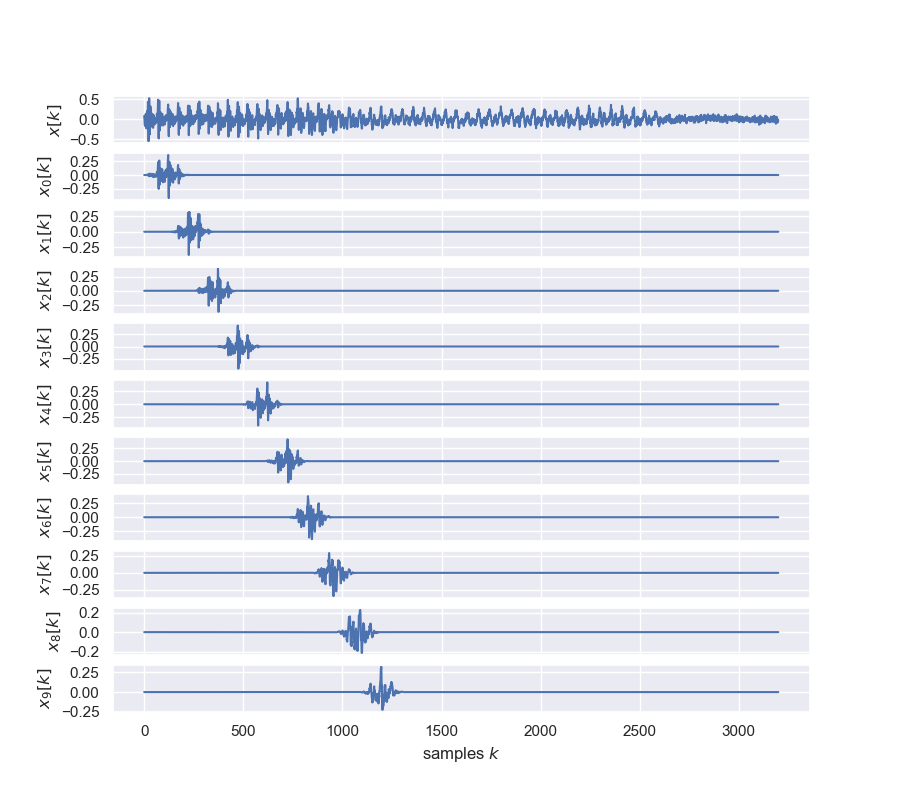

In [10]:
#This figure is being added to the tutorial instead after being polished
T_start = 1.4             # start time of cut-out in seconds
T_end   = 1.8             # end time of cut-out in seconds
sample  = y[int(fs*T_start):int(fs*T_end)]  # cut out of T seconds

# use our function to get the windows signal chunks / frames
windowed = get_windowed_chunks(sample, window_choice = 'Blackman')

# visualise the result
plt.figure(figsize=(9,8))
plt.subplot(11,1,1)
plt.plot(sample)
plt.ylabel('$x[k]$')
for i,w in enumerate(windowed[:10]):
    plt.subplot(11,1,i+2)
    plt.plot(w,label='frame '+str(i) )
    plt.ylabel('$x_'+str(i)+'[k]$')
plt.xlabel('samples $k$');

## Princeton-Bradley Criteria

A desired property of the windowing process used in an Overlap-Add algorithm is that the windowing iteslf should not significantly alter the original signal after signal reconstruction. This is known as the Princeton-Bradley Criteria.


<br>
<a id='task_3'></a>
<div class="alert alert-block alert-info">
    
**Task 3: Princeton-Bradley Criteria**
    
    
<ul>
<li> Try your windowing function with the chunk length of 0.03 seconds and window_choice = 'Blackman'. Do you think the output from this configuration satisfies the Princeton-Bradley Criteria? <br>
    <strong>Hint</strong>: You can test this by simply summing the outputs (windowed segments) and by calculating the difference to the microphone signal before splitting into frames and windowing.
</li>     
<li>
    Do the same using the Hanning window.
</li>
</ul>
</div>

<IPython.core.display.Javascript object>


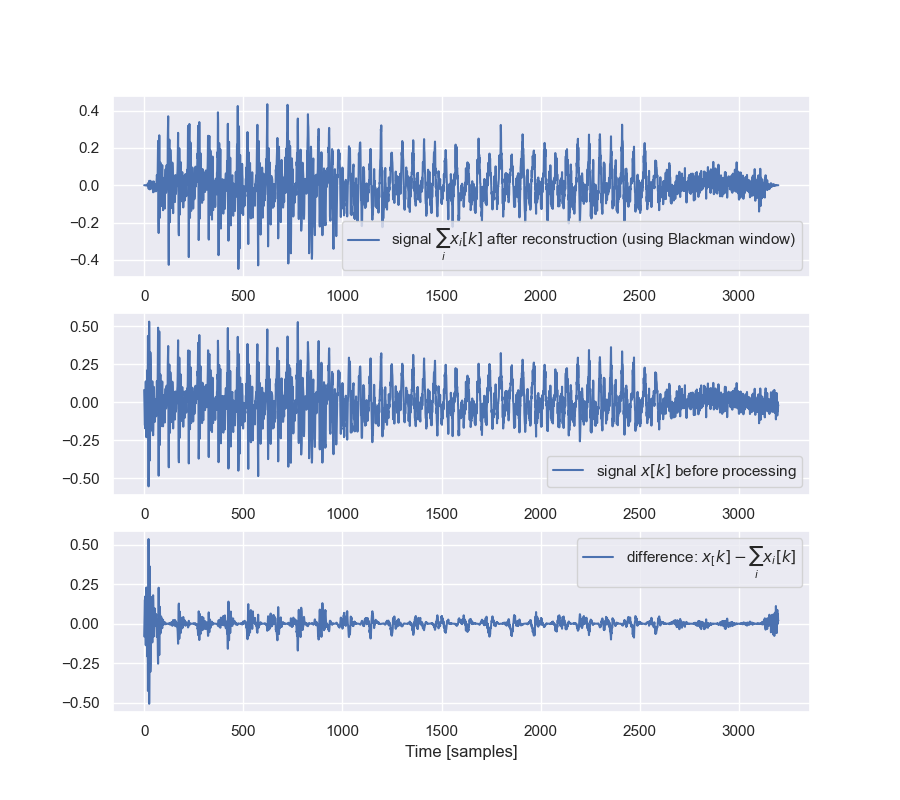

In [11]:
reconstructed = sum([chunk for chunk in windowed])
plt.figure(figsize=(9,8))
plt.subplot(3,1,1)
plt.plot(reconstructed,label='signal $\sum_i x_i[k]$ after reconstruction (using Blackman window)')
plt.legend()
plt.subplot(3,1,2)
plt.plot(sample,label='signal $x[k]$ before processing')
plt.legend()
plt.subplot(3,1,3)
plt.plot(reconstructed-sample,label='difference: $x_[k] - \sum_i x_i[k]$')
plt.legend()
plt.xlabel('Time [samples]');

We see from the figure above that the Blackman window function leads to artifacts when reconstruction the signal again. Note that besides applying a window and resynthesising the signal again we did not apply any actual filtering yet. Therefore we want that the resynthesised signal does not have major differences from our original signal. We can conclude that for using the *Blackman window* the *Princeton-Bradley Criteria* is not fulfilled. Let's check for another window, i.e. the *Hanning window*.

<IPython.core.display.Javascript object>


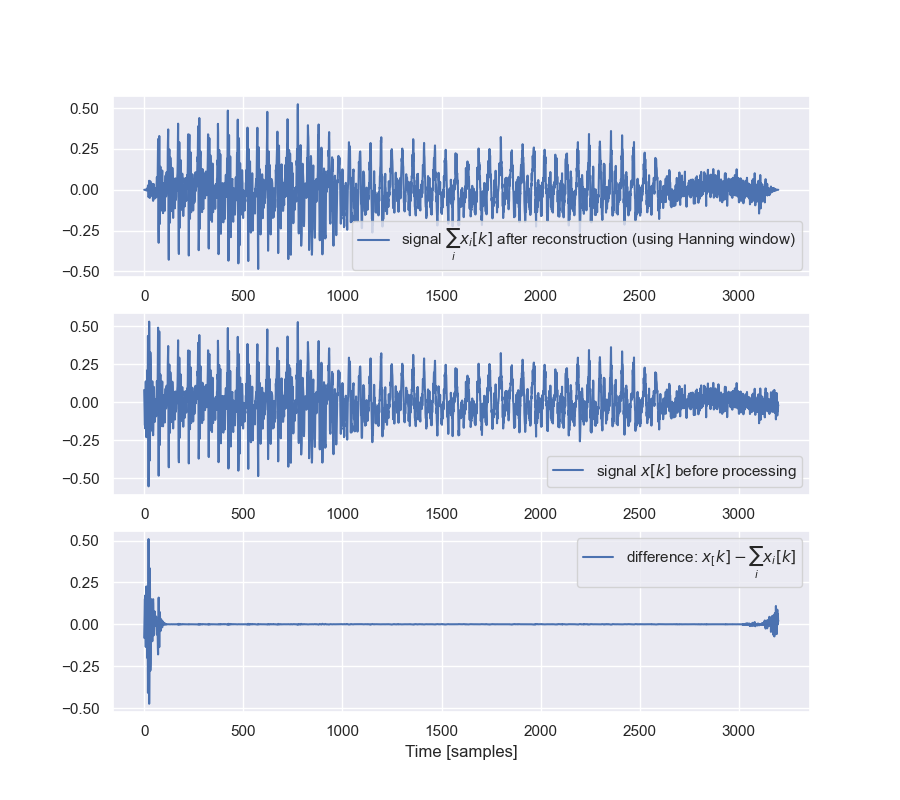

In [12]:
windowed_Hanning = get_windowed_chunks(sample, window_choice = 'Hanning')
reconstructed = sum([w for w in windowed_Hanning])
plt.figure(figsize=(9,8))
plt.subplot(3,1,1)
plt.plot(reconstructed,label='signal $\sum_i x_i[k]$ after reconstruction (using Hanning window)')
plt.legend()
plt.subplot(3,1,2)
plt.plot(sample,label='signal $x[k]$ before processing')
plt.legend()
plt.subplot(3,1,3)
plt.plot(reconstructed-sample,label='difference: $x_[k] - \sum_i x_i[k]$')
plt.legend()
plt.xlabel('Time [samples]');

The figure above shows that, when using the Hanning window) the signal is reconstructed without much errors (with the exeption of the very beginning and very and, which we ignore for the time being). In other words: using the *Hanning window* fulfils the *Princeton-Bradley Criteria*.

## Overlap-Add Function
<br>
<a id='task_1'></a>
<div class="alert alert-block alert-info">
    
**Task 5: Create a function from scratch which implements the Overlap-Add to perform Finite Impulse Response filtering.**
    
<ul>
<li> Create an instance of an FIR filter from the scipy.signal.firwin() and plot the impulse response of the filter.
</li>     
<li> 
   Create a function which: performs windowing (zero padding here is no longer necessary), transforms both the filter and windows to the frequency domain via np.fft.rfft(), and reconstructs the filtered signal.
</li> 
</ul>
</div>

<class 'numpy.ndarray'>


<IPython.core.display.Javascript object>


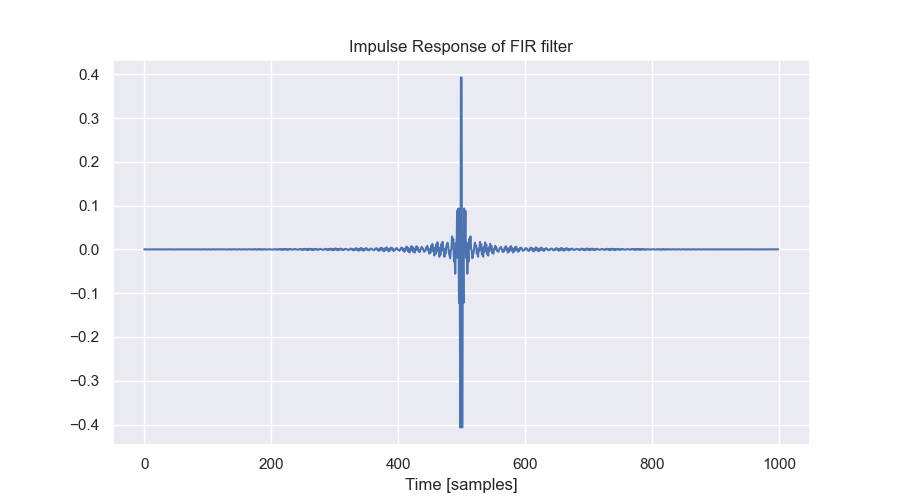

In [13]:
def overlap_add_filtering(signal, filt, L_I):
    """
    Overlap-Add filtering.
    
    Input:
        signal: np.array or list
            input signal to process
        filt: np.array
            impulse response of FIR filter
        L_I: int
            length of FIR filter
    Output:
        filtered signal
    
    Example:
       overlap_add_filtering(signal, testfilt, 1000)
    """
    bits_to_shift_by = (L_I-1).bit_length() # number of bits necessary to represent in binary
    L_F = 2<<bits_to_shift_by               # length of fourier transform window
    L_W = L_F - L_I + 1 # length of signal to be filtered in single window overlap iteration
    
    filt_F = np.fft.rfft(filt, n=L_F) # filter in frequency domain
    
    windows = [w for w in range(0, len(signal), L_W)]
    
    windows_f = []
    for w in windows:
        signal_w = signal[w:w+L_W] # windowed signal
        signal_w_F = np.fft.rfft(signal_w, n=L_F) #windowed signal in frequency domain
        windows_f.append(np.fft.irfft(signal_w_F*filt_F)) #filtered windowed signal in time domain 
    
    signal_f = np.zeros(len(signal) + L_F)
    for i,n in enumerate(windows):
        signal_f[n:n+L_F] += windows_f[i]
        
    return signal_f[:len(signal)] #truncate to length of original signal


#create instance of FIR filter and plot impulse response

L_I = 1000 # impulse response (number of samples)

# create filter
testfilt = sig.firwin(L_I, [1000, 3900], nyq=fs/2, pass_zero=False) #num_taps (filter order + 1), cutoff frequency 
print(type(testfilt))
plt.figure(figsize = (9,5))
plt.plot(testfilt)
plt.title('Impulse Response of FIR filter')
plt.xlabel('Time [samples]');

In [14]:
sig.wiener?

## Computational Effeciency of Overlap-Add

<br>
<a id='task_1'></a>
<div style="border: 2px solid #999; padding: 10px; background: #eee;">
    
**Task 5: Compare the speed of your Overlap-Add filtering function with using scipy's function.**
    
<ul>
<li> 
   Use %timeit to record the time taken for scipy.signal.lfilter() to operate on your filter.
</li> 
<li>
   Do the same with your overlap_add_filtering_function, compare speed.
</li>
</ul>
</div>

In [15]:
#filter with sig.lfilter and record time
%timeit sig.lfilter(testfilt, [1, ], y)
scipy_filtered = sig.lfilter(testfilt, [1, ], y)
%timeit overlap_add_filtering(y, testfilt, L_I)
oa_filtered = overlap_add_filtering(y, testfilt, L_I)

36.6 ms ± 4.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
15.4 ms ± 2.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<IPython.core.display.Javascript object>


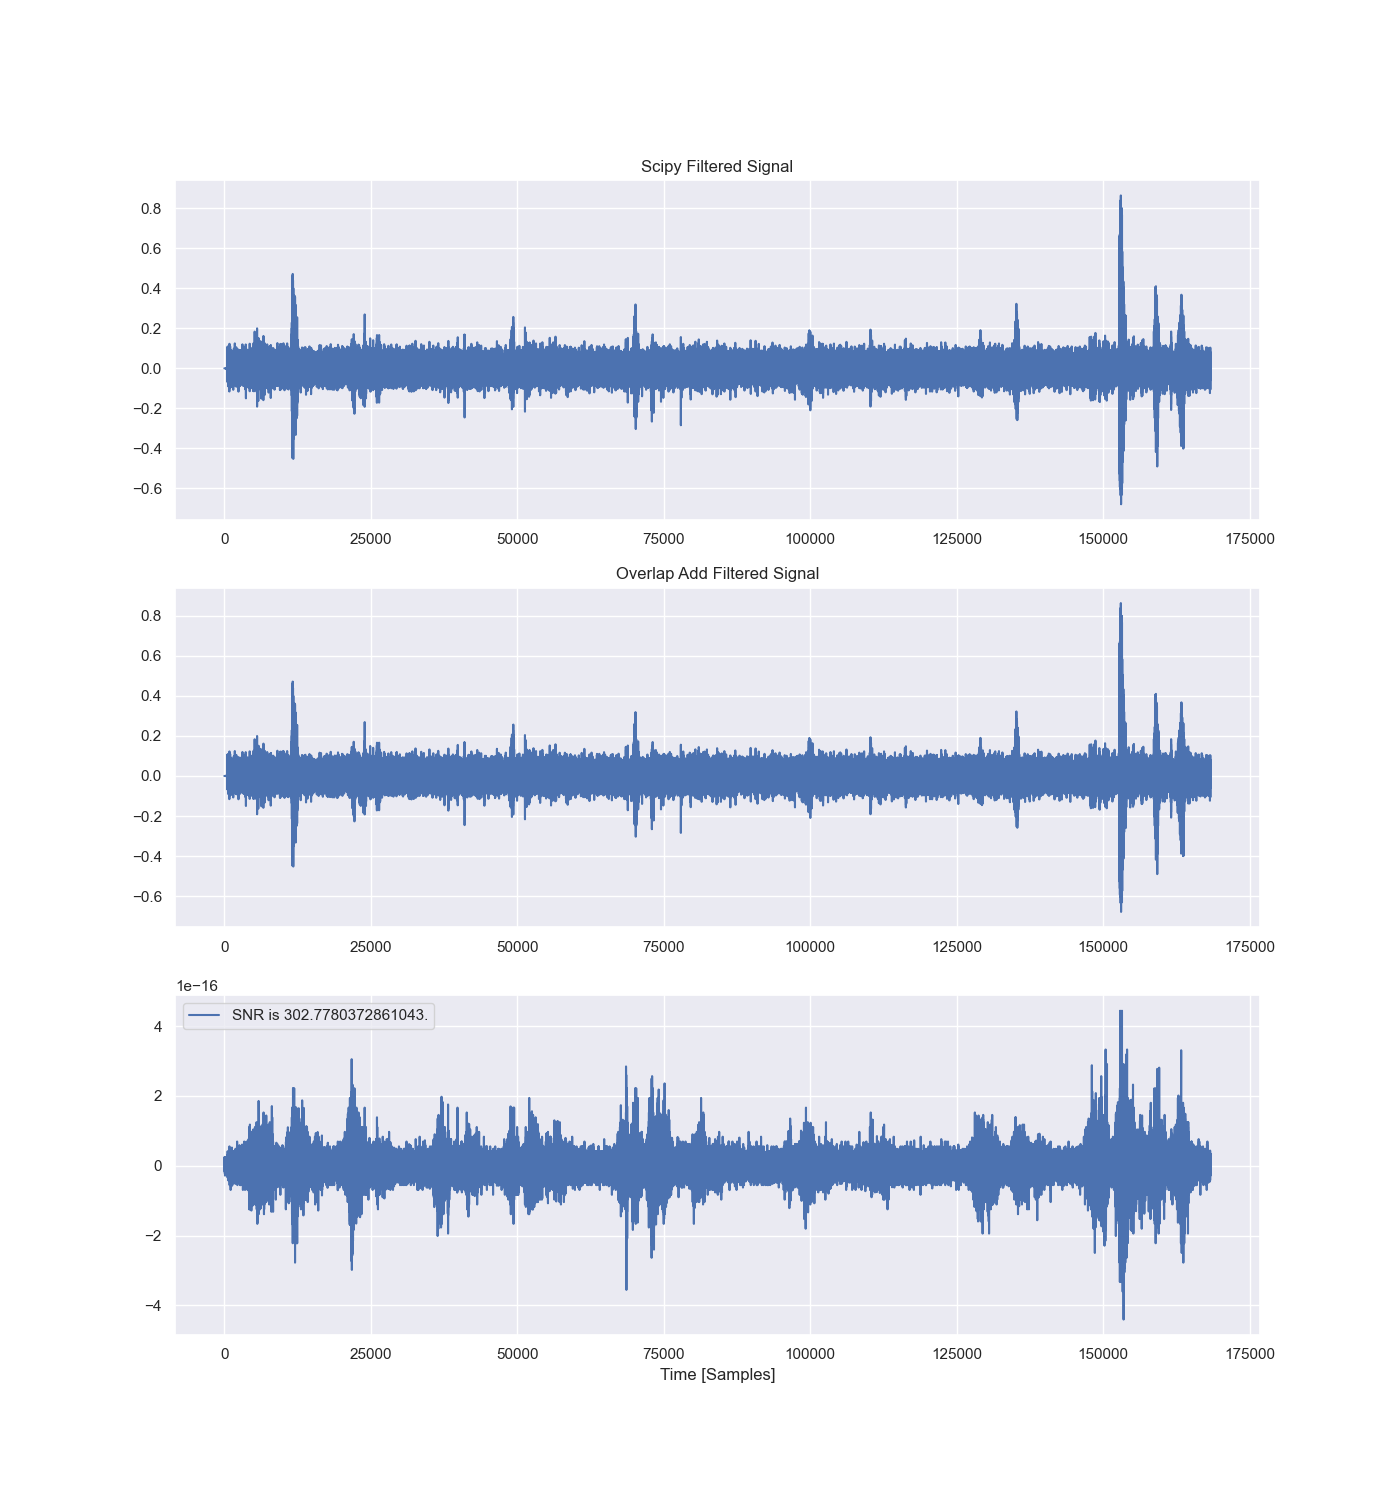

Text(0.5, 0, 'Time [Samples]')

In [16]:
plt.figure(figsize =(14,15))
plt.subplot(3,1,1)
plt.plot(scipy_filtered)
plt.title('Scipy Filtered Signal')
plt.subplot(3,1,2)
plt.plot(oa_filtered)
plt.title('Overlap Add Filtered Signal')
plt.subplot(3,1,3)
sn = 'SNR is {}.'.format(10*np.log10(np.sum(oa_filtered**2)/np.sum((oa_filtered-scipy_filtered)**2)))
plt.plot(oa_filtered-scipy_filtered, label = sn)
plt.legend()
plt.xlabel('Time [Samples]')

# Autocorrelation and Power Spectral Density

The autocorrelation of signal $x[k]$, $r_{xx}[\tau]$ where $\tau$ is the delay, is a measure of the similarity between a signal and a delayed version of itself.

$$ r_{xx}[\tau] = \sum_{k=-\infty}^{\infty} x[k] \cdot x[k-\tau] $$

<div style="text-align:center;">
    <img src="autocorrelation.gif" alt="Relation between unit circle and the sine/cosine generation." style="width: 500px;"/>
    <span style="font-size:smaller">
        <b>Fig. 1:</b> Autocorrelation of a simple sinusoidal signal.
    </span>
</div>
The Power Spectral Density (PSD) of signal $x$, $\Phi_{xx}[f]$, is the Fourier Transform of the autocorrelation function (and the vice-versa). It is a measure of a signal's power intensity in the frequency domain. Effectively, the PSD describes how the power of a signal is distributed over frequency. 

$$ \Phi_{xx}[f] = \sum_{\tau=-\infty}^{\infty} r_{xx}[\tau]e^{-j2\pi f\tau}$$

$$ r_{xx}[k] = \int_{-\infty}^{\infty} \Phi_{xx}[f] e^{j2\pi fk} df $$

<br>
<a id='task_3'></a>
<div class="alert alert-block alert-info">
    
**Task 5: Autocorrelation and Power Spectral Density**
    
    
<ul>
<li> Implement the autocorrelation formula as a python function, apply and visualise the outputs for both your noisy microphone signal and a simple sinusoid of your choosing. 
</li>     
<li>
    By taking the discrete time Fourier Transform of the autocorrelation (as per equation...), do the same for the PSD.
</li>
</ul>
</div>

<IPython.core.display.Javascript object>


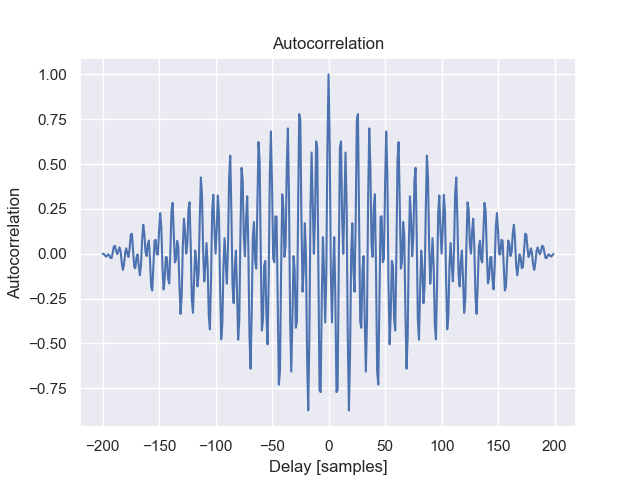

<IPython.core.display.Javascript object>


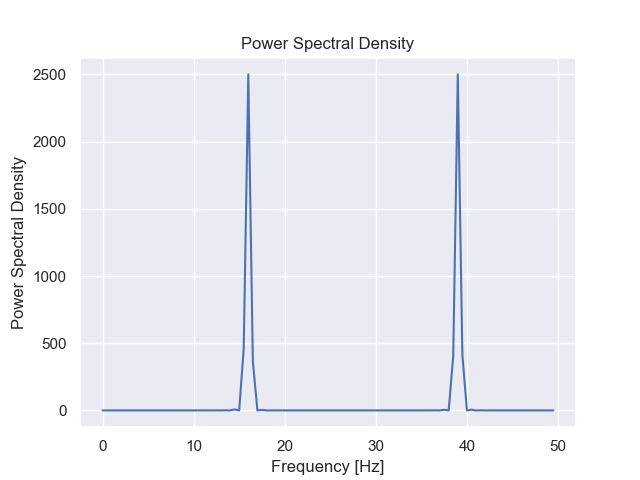

In [17]:
import math
import matplotlib.pyplot as plt

def autocorrelation(signal, delays):
    r_ss = []
    for delay in delays:
        shifted_signal = [0]*abs(delay) + signal[:-abs(delay)] if delay < 0 else signal[abs(delay):] + [0]*abs(delay)
        r_ss.append(sum(x*y for x, y in zip(signal, shifted_signal)))
    return r_ss

def PSD(r_ss):
    N = len(r_ss)
    Phi_ss = []
    for k in range(N):
        re = sum(r_ss[n]*math.cos(2*math.pi*k*n/N) for n in range(N))
        im = sum(r_ss[n]*math.sin(2*math.pi*k*n/N) for n in range(N))
        Phi_ss.append(re**2 + im**2)
    return Phi_ss

# create simple sinusoid
sr = 200
length = 1
t = [i/sr for i in range(int(length*sr))]
f = 16
f2 = 39
x = [math.sin(2*math.pi*f*i)+math.cos(2*math.pi*f2*i) for i in t]

# create array of delays to shift signal by
delays = list(range(-len(x), len(x)))

# apply autocorrelation function
r_xx = autocorrelation(x, delays)

# normalize autocorrelation
r_xx = [val/r_xx[len(x)] for val in r_xx]

# plot autocorrelation
plt.figure()
plt.plot(delays, r_xx)
plt.xlabel('Delay [samples]')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation')
plt.show()

# apply PSD function
Phi_xx = PSD(r_xx)

# create frequency vector
frequencies = [i*sr/len(r_xx) for i in range(len(r_xx))]

# plot PSD
nyquist_freq = sr // 2
plt.figure()
plt.plot(frequencies[:nyquist_freq], Phi_xx[:nyquist_freq])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.title('Power Spectral Density')
plt.show()


# Distinction from Fourier Transform

While the Fourier Transform provides a frequency-domain representation of a signal, it does not provide any information about the power distribution over frequency. On the other hand, the PSD provides information about the power distribution over frequency, which is crucial for understanding the energy characteristics of the signal.

Show that the fourier transform represents the amplitude of the signal, and the power spectral density represents the energy of the frequency since it is the amplitude squared.

**Task 6: Compare with discrete time Fourier Transform of signal**
    
    
<ul>
<li> Apply a discrete time Fourier Transform using np.fft.dfft to your simple sinusoid
</li>     
<li>
    Visualise the results with appropriate axis labels including suitable units.
</li>
<li>
    Compare with the PSD of the simple sinusoid, what do you notice about the values for the amplitudes of the frequency spikes? (amplitude of DFT of a signal is the relative amplitude normalised by signal length and halved, amplitude of PSD is energy per Hz) 
</li>
</ul>
</div>

In [18]:
# Task 6

# Cross-correlation Cross Spectral Density


The cross-correlation of two signals $x[k]$ and $y[k]$, $r_{xy}[\tau]$ where $\tau$ is the delay, is a measure of the similarity between a signal and a delayed version of a second signal.

$$ r_{xy}[\tau] = \sum_{k=-\infty}^{\infty} x[k] \cdot y[k-\tau] $$


The Cross Spectral Density (CSD) of two signals $x$ and $y$, $\Phi_{xy}[f]$, is the Fourier Transform of the cross-correlation function (and vice-versa). It is a measure of a signal's power intensity in the frequency domain. Effectively, the CSD describes how the power of a signal is distributed over frequency. 

$$ \Phi_{xy}[f] = \sum_{\tau=-\infty}^{\infty} r_{xy}[\tau]e^{-j2\pi f\tau}$$

$$ r_{xy}[k] = \int_{-\infty}^{\infty} \Phi_{xy}[f] e^{j2\pi fk} df $$

<br>
<a id='task_3'></a>
<div class="alert alert-block alert-info">
    
**Task 6: cross-correlation and Cross Spectral Density**
    
    
<ul>
<li> Implement the cross-correlation formula and CSD formula as python functions, apply and visualise the outputs for two simple sinusoids of your choosing. 
</li>     
<li>
    Apply your cross-correlation and CSD formula to your two uncorrelated signals (random noise), visualise the output. What do you notice?
</li>
</ul>
</div>

<IPython.core.display.Javascript object>


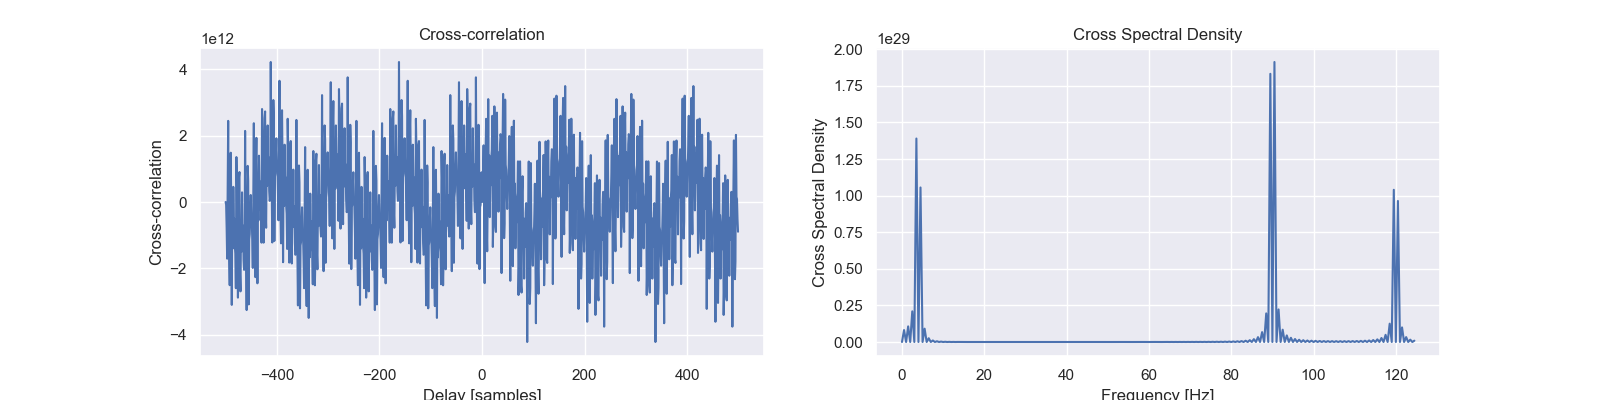

<IPython.core.display.Javascript object>


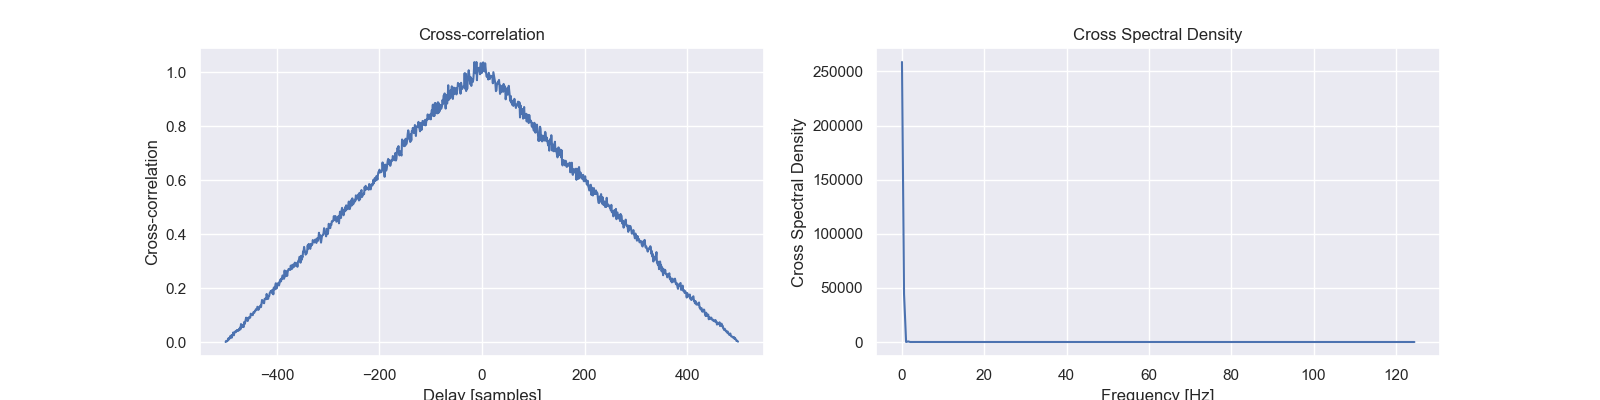

Text(0.5, 1.0, 'Cross Spectral Density')

In [19]:
import math
import matplotlib.pyplot as plt
import random

def crosscorrelation(signal1, signal2, delays):
    r_xy = []
    for delay in delays:
        shifted_signal = [0]*abs(delay) + signal2[:-abs(delay)] if delay < 0 else signal2[abs(delay):] + [0]*abs(delay)
        r_xy.append(sum(x*y for x, y in zip(signal1, shifted_signal)))
    return r_xy

def CSD(r_xy):
    N = len(r_xy)
    Phi_xy = []
    for k in range(N):
        re = sum(r_xy[n]*math.cos(2*math.pi*k*n/N) for n in range(N))
        im = sum(r_xy[n]*math.sin(2*math.pi*k*n/N) for n in range(N))
        Phi_xy.append(re**2 + im**2)
    return Phi_xy

# create simple sinusoids
sr = 500
length = 1
t = [i/sr for i in range(int(length*sr))]
f1 = 4
f2 = 120
f3 = 240
x1 = [math.sin(2*math.pi*f1*i)+math.cos(2*math.pi*f2*i)+math.sin(2*math.pi*f3*i) for i in t]
f1 = 32
f2 = 90
f3 = 180
x2 = [math.sin(2*math.pi*f2*i)+math.cos(2*math.pi*f2*i)+math.sin(2*math.pi*f3*i) for i in t]

# create array of delays to shift signal by
delays = list(range(-len(x1), len(x1)))

# apply cross-correlation function
r_xy = crosscorrelation(x1, x2, delays)

# normalize cross-correlation
r_xy = [val/r_xy[len(x1)] for val in r_xy]

# plot cross-correlation
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(delays, r_xy)
plt.xlabel('Delay [samples]')
plt.ylabel('Cross-correlation')
plt.title('Cross-correlation')

# apply CSD function
Phi_xy = CSD(r_xy)

# create frequency vector
frequencies = [i*sr/len(r_xy) for i in range(len(r_xy))]

# plot CSD
nyquist_freq = sr // 2
plt.subplot(1,2,2)
plt.plot(frequencies[:nyquist_freq], Phi_xy[:nyquist_freq])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Cross Spectral Density')
plt.title('Cross Spectral Density')

# create simple sinusoids
sr = 500
length = 1
t = [i/sr for i in range(int(length*sr))]

# create two random signals
x1 = [random.random() for _ in t]
x2 = [random.random() for _ in t]

# create array of delays to shift signal by
delays = list(range(-len(x1), len(x1)))

# apply cross-correlation function
r_xy = crosscorrelation(x1, x2, delays)

# normalize cross-correlation
r_xy = [val/r_xy[len(x1)] for val in r_xy]

# plot cross-correlation
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(delays, r_xy)
plt.xlabel('Delay [samples]')
plt.ylabel('Cross-correlation')
plt.title('Cross-correlation')

# apply CSD function
Phi_xy = CSD(r_xy)

# create frequency vector
frequencies = [i*sr/len(r_xy) for i in range(len(r_xy))]

# plot CSD
nyquist_freq = sr // 2
plt.subplot(1,2,2)
plt.plot(frequencies[:nyquist_freq], Phi_xy[:nyquist_freq])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Cross Spectral Density')
plt.title('Cross Spectral Density')




# Weiner Filtering with Power Spectral Densities

The [Wiener filter](https://en.wikipedia.org/wiki/Wiener_filter) is a linear time-invariant filter that minimizes the mean square error between the estimated clean speech signal $\hat{s}[k]$ and the desired signal $s[k]$. As mentioned earlier, suppose we have a noisy signal $y[k] = s[k] + n[k]$, where $s[k]$ is the desired signal (clean speech) and $n[k]$ is the additive noise. We want to find a filter $h[k]$ such that the output $\hat{s}[k] = y[k] * h[k]$ is as close to $s[k]$ as possible; minimising the mean square error between $\hat{s}[k]$ and $s[k]$. 

The mean square error is given below, where $\mathrm{E}[\cdot]$ denotes the [Expectation Operator](https://www.dsprelated.com/freebooks/sasp/Expected_Value.html).

$$\epsilon = \frac{1}{K}\sum_{k = 0}^{K}{(s[k] - \hat{s}[k])^2} = \mathrm{E}[(s[k] - \hat{s}[k])^2]$$

Applying [Parseval's theorem](https://en.wikipedia.org/wiki/Parseval_theorem) and substituing the transfer function of the desired Weiner filter we can reformulate the MSE in the frequency domain: 
\begin{align*}
\epsilon &= \frac{1}{2\pi} \int^{\pi}_{-\pi} \mathrm{E}[|S(f)-\hat{S}(f)|^2]\ df \\
\epsilon &= \frac{1}{2\pi} \int^{\pi}_{-\pi} \mathrm{E}[|S(f)-H(f)Y(f)|^2]\ df
\end{align*}

To minimize $\epsilon$, we take the partial derivative with respect to $H[f]$ and set the result to zero.
\begin{align*}
\frac{\partial \epsilon}{\partial H[f]} &= -\mathrm{E}[Y(f)S^*(f)]\ df + \mathrm{E}[Y(f)Y^*(f)]H^*(f)\ df \\
0 &= -\mathrm{E}[Y(f)S^*(f)]\ df + \mathrm{E}[Y(f)Y^*(f)]H^*(f)\ df 
\end{align*}

Yielding an equation for the complex conjugate of transfer function of the desired Weiner filter, $H^*(f)$.

\begin{align*}
H^*(f) &= \frac{\mathrm{E}[Y(f)S^*(f)]}{\mathrm{E}[Y(f)Y^*(f)]} \\
H^*(f) &= \frac{\mathrm{E}[Y(f)S^*(f)]}{\mathrm{E}[|Y(f)|^2]}
\end{align*}
Giving us an equation for the transfer function of the desired Weiner filter:

$$H(f) = \frac{\mathrm{E}[Y^*(f)S(f)]}{\mathrm{E}[|Y(f)|^2]}$$

Substituting $Y^*(f) = S^*(f) + N^*(f)$ into the above formula gives:

\begin{align*}
H(f) &= \frac{\mathrm{E}[S(f)(S^*(f) + N^*(f))]}{\mathrm{E}[|Y(f)|^2]} \\
H(f) &= \frac{\mathrm{E}[S(f)(S^*(f)) + \mathrm{E}[S(f)N^*(f)])}{\mathrm{E}[|Y(f)|^2]} \\
\end{align*}

Given $\Phi_{OO}\propto \mathrm{E}[|O(f)|^2]$:

$$H(f) = \frac{\Phi_{SS} + \Phi_{SN}}{\Phi_{YY}}$$

We can assume the speech signal and the noise signal are uncorrelated, setting the cross spectral density between the two $\Phi_{SN}$ to zero, as demonstrated earlier:

$$H(f) = \frac{\Phi_{SS}}{\Phi_{YY}}$$

and: 

\begin{align*}
\mathrm{E}[|Y(f)|^2] &= \mathrm{E}[|S(f) + N(f)|^2] \\
\mathrm{E}[|Y(f)|^2] &= \mathrm{E}[S(f)S^*(f)] + \mathrm{E}[S(f)N^*(f)] + \mathrm{E}[N(f)S^*(f)] + \mathrm{E}[N(f)N^*(f)]
\end{align*}

So finally, the transfer function for a noisy microphone signal where the noise of the speech is uncorreled with the noise in terms of their respective PSD's:

$$
H(f) = \frac{\Phi_{SS}}{\Phi_{SS} + \Phi_{NN}}
$$






### Estimating the Noise Signal's PSD

\begin{equation}
\Phi_{YY}[n,\ell] = (1-\alpha) \Phi_{YY}[n,\ell-1] + \alpha |Y([n,\ell])|^2
\end{equation}

\begin{equation}
\alpha = 0.9 \mbox{if speech active}
\end{equation}

### Estimating the Noise  PSD


\begin{equation}
\Phi_{NN}[n,\ell] = (1-\beta) \Phi_{NN}[n,\ell-1] + \beta |N([n,\ell])|^2
\end{equation}

for speech NOT active, 
\begin{equation}
N([n,\ell]) = Y([n,\ell])
\end{equation}

$\beta$ depends on VAD

\begin{equation}
\beta = 0 \mbox{if speech active}
\end{equation}
\begin{equation}
\beta = 0.9 \mbox{if speech not active}
\end{equation}

#### VAD
oracle VAD: Short Term-Energy from Lab Sheet 3 - start with the respective last plot for ZCR or shrt-term-energy and then you have the VAD

$|s_\mathrm{RMS}[k]| > $ threshold (0.2) per block

ORACLE VAD IN MATLAB:

```
vad_inds=zeros(size(speech));
vad_inds(abs(speech)>10^(-20/10)) = 1;
vad_vector2=zeros(blocks,1);
for K=1:blocks,
    ind=(K-1)*blocksize+1 : K*blocksize;
    vad_vector2(K) = max(vad_inds(ind));
    vad_inds2(ind) = max(vad_inds(ind));
end
%figure;plot(speech(1:blocksize:end));hold on;plot(vad_vector,'r');plot(vad_vector2,'g');legend('speech signal','vad2','vad2');
vad_vector = vad_vector2;
```


In [ ]:
for kk in range(2):
    weighting = 
    

## Copyright

This notebook is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) to be used during the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield"). You may download, [clone](https://docs.github.com/en/repositories/creating-and-managing-repositories/cloning-a-repository) or [fork](https://docs.github.com/en/get-started/quickstart/fork-a-repo) it to your computer or private [GitHub](https://github.com/) account. 

### Contributors
[Stefan Goetze](http://www.stefan-goetze.de "Web page of Stefan Goetze"),
[Jason Clarke](https://github.com/jclarke98)